In [43]:
def new_rank_extract(id: np.ndarray,
                     next_id: np.ndarray,
                     outlet_id = -9999,
                     save_path = None):
    """
    This function is used to build the Rank and Next vairables for the Drainage Database of MESH model
    Written: Ala Bahrami, Cooper Albano
    Inputs:
        id:        an array of unique river segment id numbers
        next_id:   an array of the next downstream segment id numbers
        outlet_id: The user specified value to representing an outlet in the next_id array
    Outputs:
        Rank:     an array of the rank of each segment in the drainage database
        Next:     an array of the next downstream segment id numbers
    """
    # load the packages
    import numpy as np
    import pandas as pd
    
    # first check that the length of id and next_id are the idential
    try:
        if len(id) != len(next_id):
            raise ValueError("Lengths of DataFrames are not equal")
    except ValueError as ve:
        print("An error occurred while comparing length of id and next_id:", ve)
        
    # make sure id and next_id are numpy array with similar dimension
    try:
        if not id.shape == next_id.shape:
            raise ValueError("id and next_id are not arrays of equal size.")
    except ValueError as ve:
        print("An error occurred in comaring the shape of id and id_next:", ve)
        
    # make sure id and next_id are 1D array
    try:
        if not id.ndim == next_id.ndim:
            raise ValueError("id and next_id are not 1D array, flatten() can be used.")
    except ValueError as ve:
        print("An error occurred in comaring the shape of id and id_next:", ve)
        
    # check if the values of id are all positive
    try:
        if not sum(id>0) == len(id):
            raise ValueError("There are negative values in the id, ids should be all positive integer")
    except ValueError as ve:
        print("An error occurred in checking the positive integer of the array:", ve)
        
    # check in case the outlet_id is nagitve, such as -9999, the native values in next_id are qual to this value
    if outlet_id < 0:
        unique_values, value_counts = np.unique(next_id[next_id < 0], return_counts=True)
        if len(unique_values) > 1:
            try:
                if len(unique_values) != 1 or unique_values[0] != outlet_id:
                    raise ValueError("There are negative values in the next_id that differe from negative outlet id of:", outlet_id)
            except ValueError as ve:
                print("An error occurred in checking the uniquness of negtive outlet number:", ve)
    
    # passing the segid and tosegmet
    segid = id
    tosegment = next_id
    
    # Make sure the outlet value for tosegment is zero
    if outlet_id > 0:
        for i in range(len(tosegment)):
            if tosegment[i] == outlet_id:
                tosegment[i]=0
    else: # for seg that their downstream is not in id turn the dowsntream to outlet_id
        for i in range(len(tosegment)):
            if not tosegment[i] in segid:
                tosegment[i]=0
    
    # Count the number of outlets
    # Find the indices of all tosegments that are zero and save to an array.
    outlets = np.where(tosegment == 0)[0]

    #% Search over to extract the subbasins drain into each outlet
    rank_id_domain = np.array([]).astype(int)   
    outlet_number = np.array([]).astype(int) 
    for k in range(len(outlets)):
        # initial step 
        #segid_target = drainage_db['seg_id'].values[outlets[k]]
        segid_target = segid[outlets[k]]
        # set the rank of the outlet 
        rank_id = outlets[k]
        
        # find upstream segids drains into downstream
        while(np.size(segid_target) >= 1): 
            if (np.size(segid_target) == 1):
                r = np.where(tosegment == segid_target)[0]
            else:
                r = np.where(tosegment == segid_target[0])[0]    
            # updated the target segid 
            segid_target = np.append(segid_target, segid[r])
            # remove the first searched target
            segid_target = np.delete(segid_target,0,0)
            if (len(segid_target) == 0):
                break
            # update the rank_id
            rank_id = np.append(rank_id,r)
        rank_id = np.flip(rank_id) 
        if (np.size(rank_id) > 1):
            outlet_number = np.append(outlet_number, (k)*np.ones((len(rank_id),1)).astype(int))
        else:
            outlet_number = np.append(outlet_number, (k))
        rank_id_domain = np.append(rank_id_domain, rank_id)
        rank_id = []
    #% reorder segid and tosegment 
    segid = segid[rank_id_domain]
    tosegment = tosegment[rank_id_domain]         
            
    # rearrange outlets to be consistent with MESH outlet structure
    # NB: In MESH outlets should be placed at the end of NEXT variable 
    NA = len(rank_id_domain)
    fid1 = np.where(tosegment != 0)[0]
    fid2 = np.where(tosegment == 0)[0]
    fid =  np.append(fid1,fid2)
    
    rank_id_domain = rank_id_domain[fid]
    segid =segid[fid]
    tosegment = tosegment[fid]
    outlet_number = outlet_number[fid]
    
    #% construct Rank and Next variables 
    Next = np.zeros(NA).astype(np.int32)
    
    for k in range(NA):
        if (tosegment[k] != 0):
            r = np.where(tosegment[k] == segid)[0] + 1 
            Next[k] = r[0]
        else:
            Next[k] = 0
            
    # Construct Rank from 1:NA
    Rank = np.arange(1,NA+1).astype(np.int32)

    # #% save subbasins reordered metadata 
    # This requires more inputs such as the domain name and output directory. Not strictly necessary for Rank and Next 
    dt = {'Merit_reorderd_ID':rank_id_domain, 'Outlet_Number':outlet_number, 
            'Rank':Rank,'Next':Next,'Segid':segid,'tosegment':tosegment}
    df = pd.DataFrame(data=dt, dtype = np.int64)
    
    if save_path:
        df.to_csv(save_path, index=False)

    return df



# Simple example 1

/Users/shg096/opt/anaconda3/envs/myenv38/lib/python3.8/site-packages/pandas/core/indexing.py:1636: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/2609126666.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/2609126666.py:27: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['y']=cat.centroid.y


0
ID: 71032440 to ID: 71029778 
 Rank: 1 to Next: 4
1
ID: 71032422 to ID: 71029778 
 Rank: 2 to Next: 4
2
ID: 71032185 to ID: 71029528 
 Rank: 3 to Next: 6
4
ID: 71029778 to ID: 71029528 
 Rank: 4 to Next: 6
3
ID: 71031893 to ID: 71029071 
 Rank: 5 to Next: 7
5
ID: 71029528 to ID: 71029071 
 Rank: 6 to Next: 7
6
ID: 71029071 to ID: 0 
 Rank: 7 to Next: 0


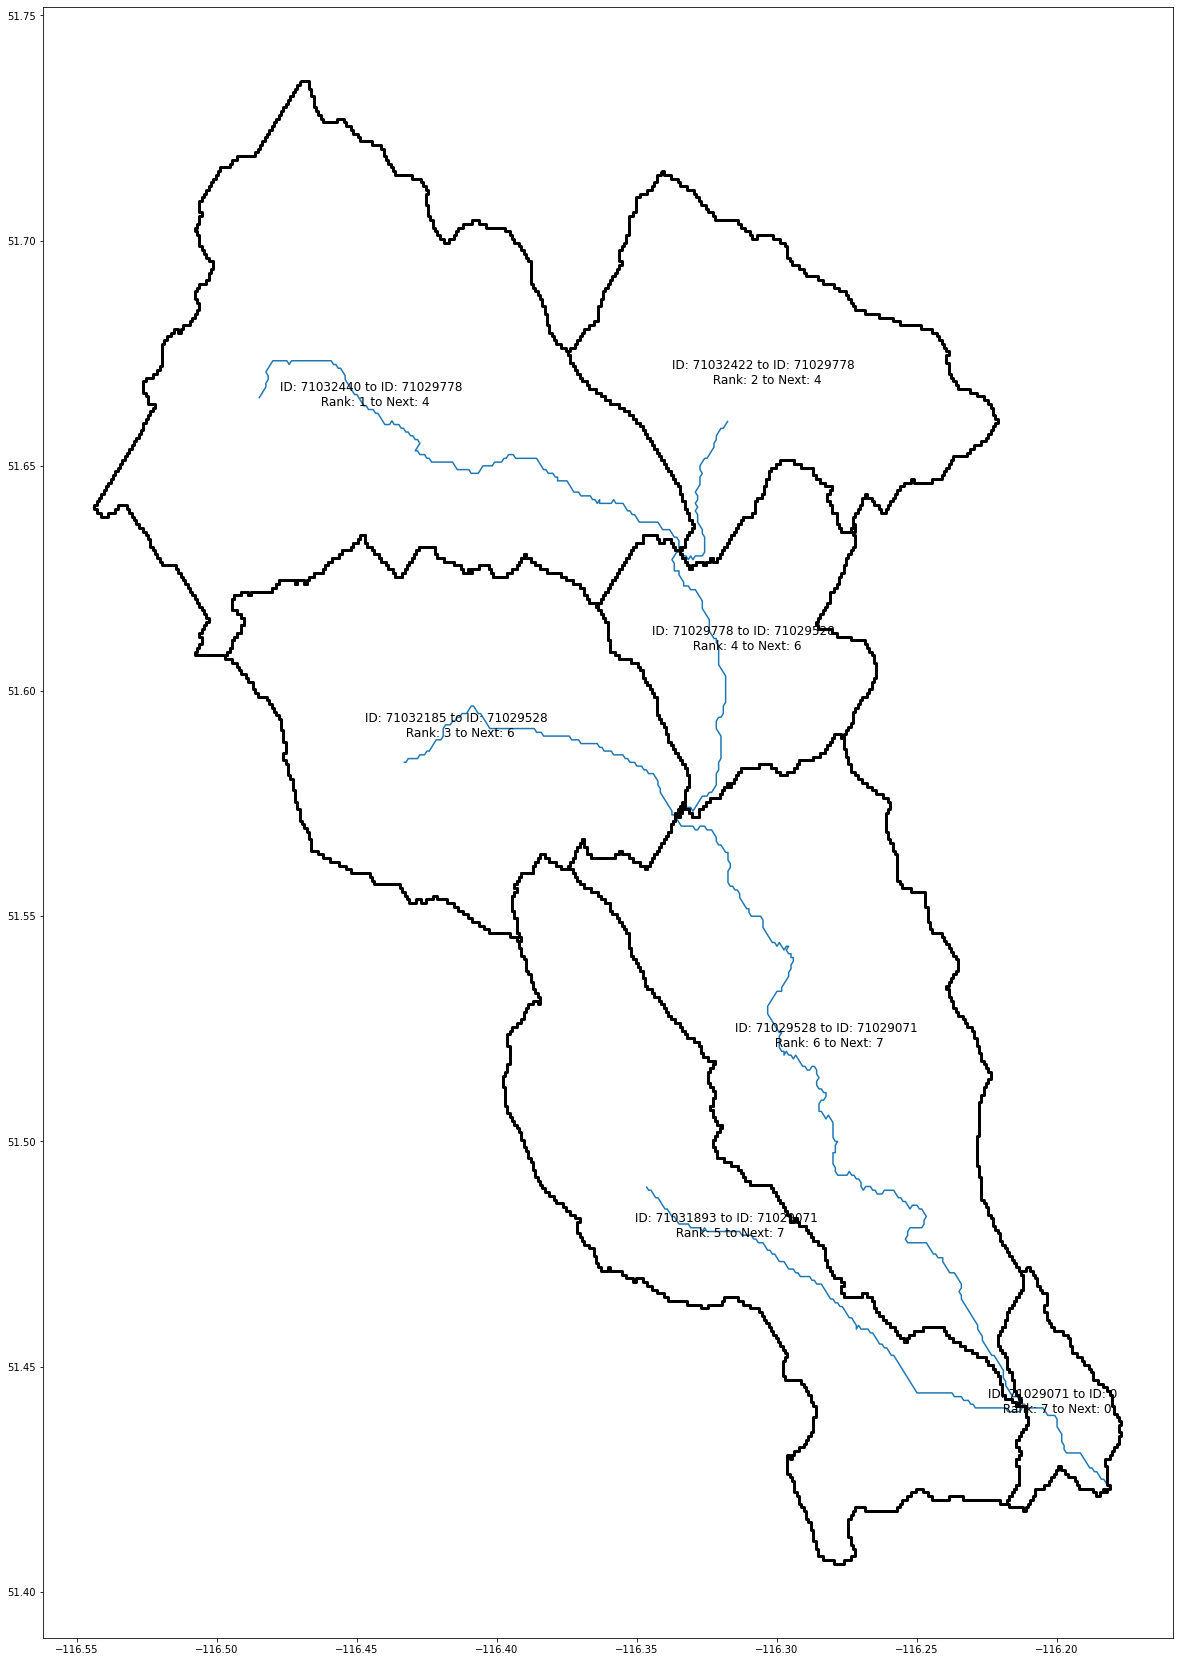

In [44]:
import geopandas as gpd
import matplotlib.pyplot as plt

cat = gpd.read_file('../data/shapefiles/catchment/BowAtLouise_cat.shp')
riv = gpd.read_file('../data/shapefiles/river_network/BowAtLouise_riv.shp')

idx = riv[riv['COMID']==71029071]
idx = idx.index.item()
riv['NextDownID'].loc[idx]=-9999.0

df = new_rank_extract(np.array(riv['COMID'].values),\
                              np.array(riv['NextDownID'].values),\
                              -9999)  # outflow at lake Loiuse 

# visualize
fig, ax = plt.subplots(figsize=(40,30))

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

#
cat.plot(ax = ax, zorder=10, color= 'none', linewidth=3)
riv.plot(ax =ax)

# print ID and rank on the map
cat['x']=cat.centroid.x
cat['y']=cat.centroid.y

for index, row in df.iterrows():
    
    # get the lat lon of centroid from cat
    cat_slice = cat [cat['COMID']==row['Segid']]
    idx = cat_slice.index.item()
    print(idx)
    
    #lat = 
    
    #
    text = 'ID: ' + str(row['Segid'])+' to ID: '+str(row['tosegment'])+' \n Rank: '+str(row['Rank'])+ ' to Next: ' +str(row['Next'])
    print(text)
    
    plt.text(cat_slice['x'].item(), cat_slice['y'].item(), text, fontsize=12, color='k', ha='center', va='center')



# simple example 2

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/1176738833.py:24: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/1176738833.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['y']=cat.centroid.y


0
ID: 71032440 to ID: 71029778 
 Rank: 1 to Next: 3
1
ID: 71032422 to ID: 71029778 
 Rank: 2 to Next: 3
4
ID: 71029778 to ID: 0 
 Rank: 3 to Next: 0
2
ID: 71032185 to ID: 0 
 Rank: 4 to Next: 0


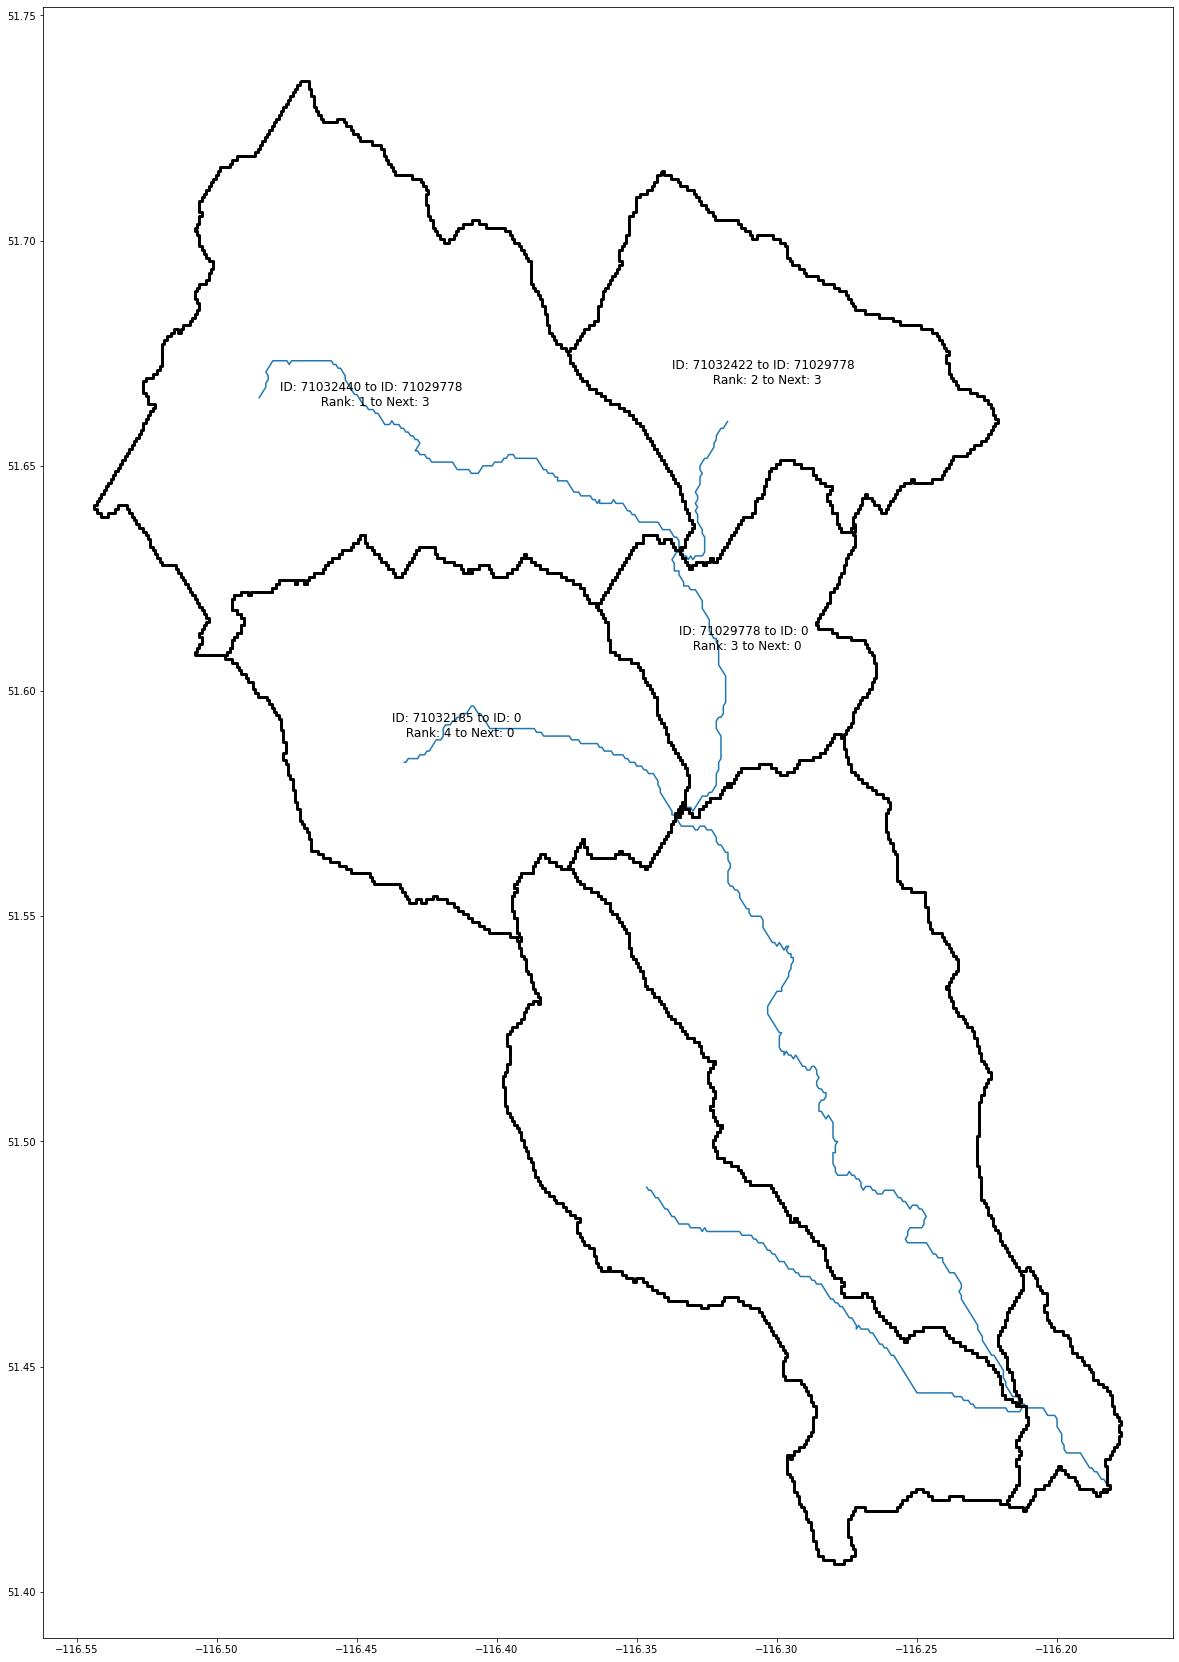

In [45]:
import geopandas as gpd
import matplotlib.pyplot as plt

cat = gpd.read_file('../data/shapefiles/catchment/BowAtLouise_cat.shp')
riv = gpd.read_file('../data/shapefiles/river_network/BowAtLouise_riv.shp')


df = new_rank_extract(np.array(riv['COMID'].values),\
                              np.array(riv['NextDownID'].values),\
                              71029528)  # outflow at lake Loiuse 


# visualize
fig, ax = plt.subplots(figsize=(40,30))

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

#
cat.plot(ax = ax, zorder=10, color= 'none', linewidth=3)
riv.plot(ax =ax)

# print ID and rank on the map
cat['x']=cat.centroid.x
cat['y']=cat.centroid.y

for index, row in df.iterrows():
    
    # get the lat lon of centroid from cat
    cat_slice = cat [cat['COMID']==row['Segid']]
    idx = cat_slice.index.item()
    print(idx)
    
    #lat = 
    
    #
    text = 'ID: ' + str(row['Segid'])+' to ID: '+str(row['tosegment'])+' \n Rank: '+str(row['Rank'])+ ' to Next: ' +str(row['Next'])
    print(text)
    
    plt.text(cat_slice['x'].item(), cat_slice['y'].item(), text, fontsize=12, color='k', ha='center', va='center')
    

# More complex example!

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/3013790545.py:31: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/3013790545.py:32: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['y']=cat.centroid.y


0
ID: 71032440 to ID: 71029778 
 Rank: 1 to Next: 3
1
ID: 71032422 to ID: 71029778 
 Rank: 2 to Next: 3
3
ID: 71029778 to ID: 0 
 Rank: 3 to Next: 0
2
ID: 71031893 to ID: 0 
 Rank: 4 to Next: 0


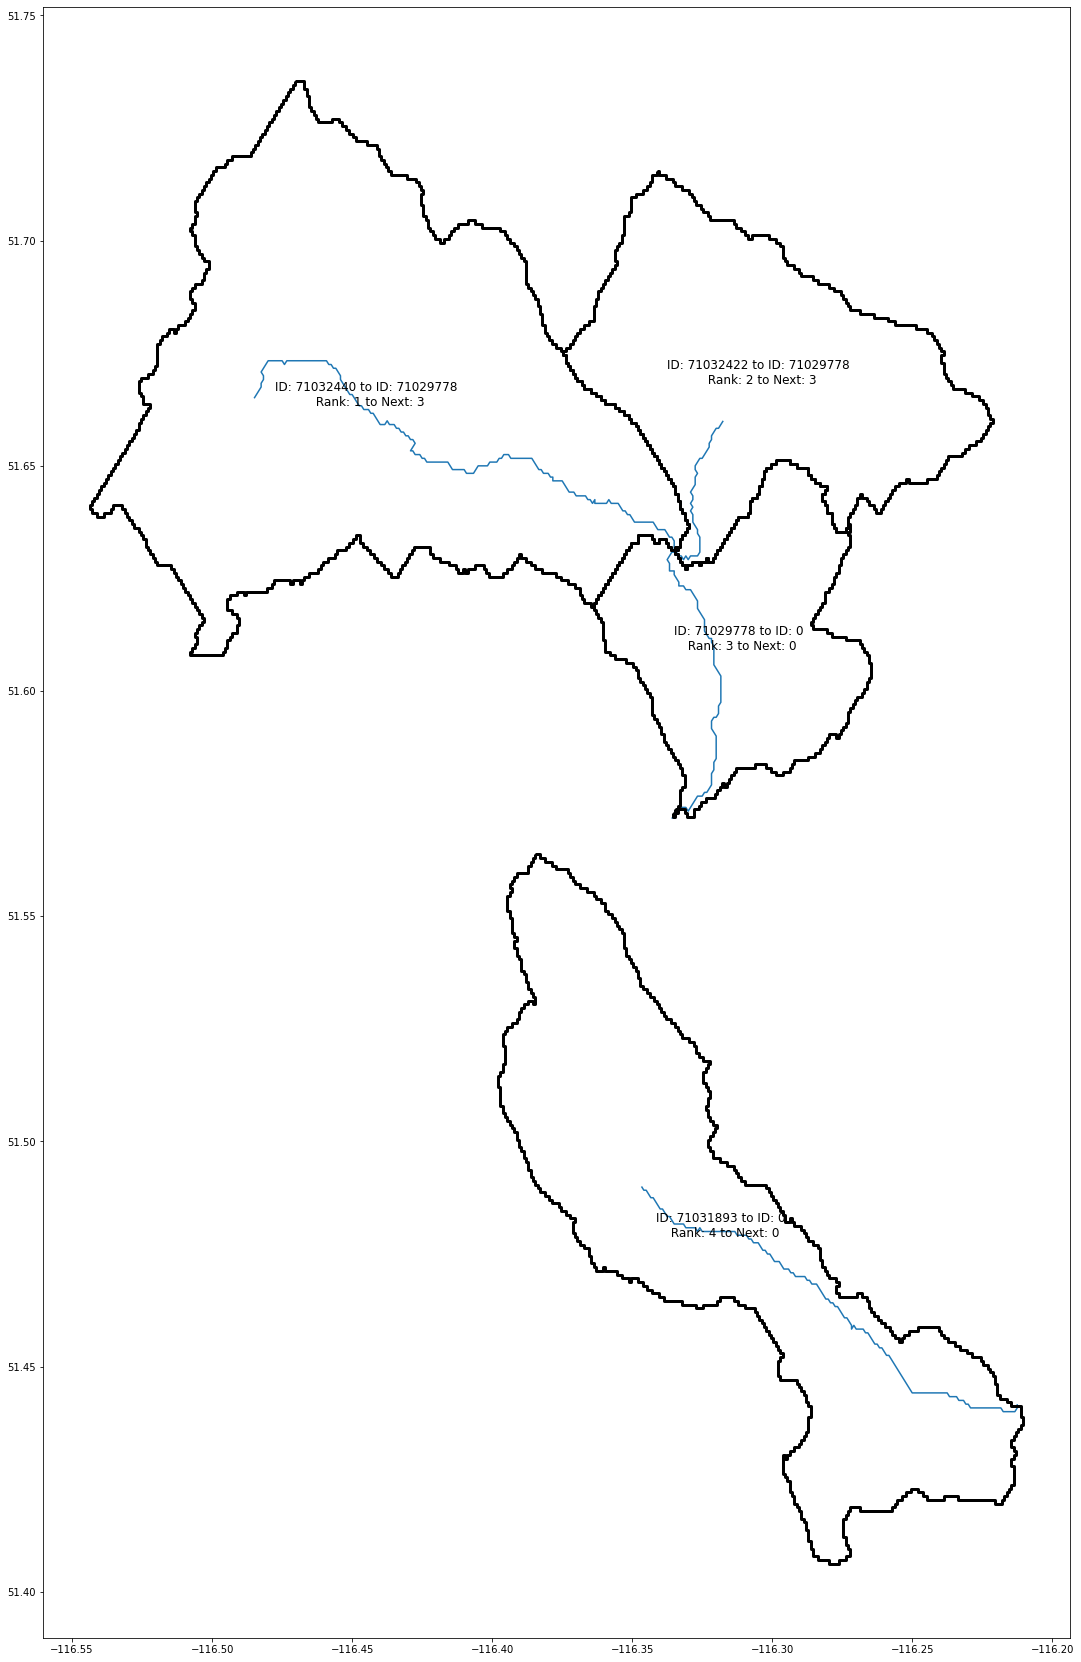

In [46]:
# another test of the code with non connected river segment
import geopandas as gpd
import matplotlib.pyplot as plt

cat = gpd.read_file('../data/shapefiles/catchment/BowAtLouise_cat.shp')
riv = gpd.read_file('../data/shapefiles/river_network/BowAtLouise_riv.shp')
cat_org = cat.copy()

# get three subbasins that are not 
cat = cat[cat['COMID'].isin([71032440,71032422,71029778,71031893])]; cat = cat.reset_index(drop=True)
riv = riv[riv['COMID'].isin([71032440,71032422,71029778,71031893])]; riv = riv.reset_index(drop=True)

df = new_rank_extract(np.array(riv['COMID'].values),\
                              np.array(riv['NextDownID'].values),\
                              -9999)  # outflow at lake Loiuse 
df


# visualize
fig, ax = plt.subplots(figsize=(40,30))

ax.set_facecolor('white')
fig.patch.set_facecolor('white')

#
cat.plot(ax = ax, zorder=10, color= 'none', linewidth=3)
#cat_org.plot(ax = ax, zorder=10, color= 'none', linewidth=0.5)
riv.plot(ax =ax)

# print ID and rank on the map
cat['x']=cat.centroid.x
cat['y']=cat.centroid.y

for index, row in df.iterrows():
    
    # get the lat lon of centroid from cat
    cat_slice = cat [cat['COMID']==row['Segid']]
    idx = cat_slice.index.item()
    print(idx)
    
    #
    text = 'ID: ' + str(row['Segid'])+' to ID: '+str(row['tosegment'])+' \n Rank: '+str(row['Rank'])+ ' to Next: ' +str(row['Next'])
    print(text)
    
    plt.text(cat_slice['x'].item(), cat_slice['y'].item(), text, fontsize=12, color='k', ha='center', va='center')
    


# Complex example 2

/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['y']=cat.centroid.y
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographi

3
ID: 71031893 to ID: 0 
 Rank: 1 to Next: 0
2
ID: 71032185 to ID: 0 
 Rank: 2 to Next: 0
1
ID: 71032422 to ID: 0 
 Rank: 3 to Next: 0
0
ID: 71032440 to ID: 0 
 Rank: 4 to Next: 0
0
ID: 71032185 to ID: 71029528 
 Rank: 1 to Next: 3
1
ID: 71029778 to ID: 71029528 
 Rank: 2 to Next: 3
2
ID: 71029528 to ID: 71029071 
 Rank: 3 to Next: 4
3
ID: 71029071 to ID: 0 
 Rank: 4 to Next: 0


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['y']=cat.centroid.y
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographi

1
ID: 71032185 to ID: 71029528 
 Rank: 1 to Next: 2
3
ID: 71029528 to ID: 0 
 Rank: 2 to Next: 0
2
ID: 71031893 to ID: 0 
 Rank: 3 to Next: 0
0
ID: 71032440 to ID: 0 
 Rank: 4 to Next: 0
0
ID: 71032185 to ID: 71029528 
 Rank: 1 to Next: 3
1
ID: 71031893 to ID: 71029071 
 Rank: 2 to Next: 4
2
ID: 71029528 to ID: 71029071 
 Rank: 3 to Next: 4
3
ID: 71029071 to ID: 0 
 Rank: 4 to Next: 0


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['y']=cat.centroid.y
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographi

1
ID: 71031893 to ID: 71029071 
 Rank: 1 to Next: 3
2
ID: 71029528 to ID: 71029071 
 Rank: 2 to Next: 3
3
ID: 71029071 to ID: 0 
 Rank: 3 to Next: 0
0
ID: 71032422 to ID: 0 
 Rank: 4 to Next: 0
1
ID: 71032185 to ID: 71029528 
 Rank: 1 to Next: 2
2
ID: 71029528 to ID: 71029071 
 Rank: 2 to Next: 3
3
ID: 71029071 to ID: 0 
 Rank: 3 to Next: 0
0
ID: 71032422 to ID: 0 
 Rank: 4 to Next: 0


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['y']=cat.centroid.y
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographi

1
ID: 71032185 to ID: 71029528 
 Rank: 1 to Next: 2
2
ID: 71029528 to ID: 71029071 
 Rank: 2 to Next: 3
3
ID: 71029071 to ID: 0 
 Rank: 3 to Next: 0
0
ID: 71032422 to ID: 0 
 Rank: 4 to Next: 0
1
ID: 71032185 to ID: 71029528 
 Rank: 1 to Next: 2
3
ID: 71029528 to ID: 0 
 Rank: 2 to Next: 0
2
ID: 71031893 to ID: 0 
 Rank: 3 to Next: 0
0
ID: 71032422 to ID: 0 
 Rank: 4 to Next: 0


/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['y']=cat.centroid.y
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  cat['x']=cat.centroid.x
/var/folders/yh/b1qy7zb96k980mcb2ps9n6d9t1c6zr/T/ipykernel_15001/338395775.py:37: UserWarning: Geometry is in a geographi

0
ID: 71032440 to ID: 71029778 
 Rank: 1 to Next: 3
1
ID: 71032422 to ID: 71029778 
 Rank: 2 to Next: 3
2
ID: 71029778 to ID: 71029528 
 Rank: 3 to Next: 4
3
ID: 71029528 to ID: 0 
 Rank: 4 to Next: 0
3
ID: 71029071 to ID: 0 
 Rank: 1 to Next: 0
2
ID: 71032185 to ID: 0 
 Rank: 2 to Next: 0
1
ID: 71032422 to ID: 0 
 Rank: 3 to Next: 0
0
ID: 71032440 to ID: 0 
 Rank: 4 to Next: 0


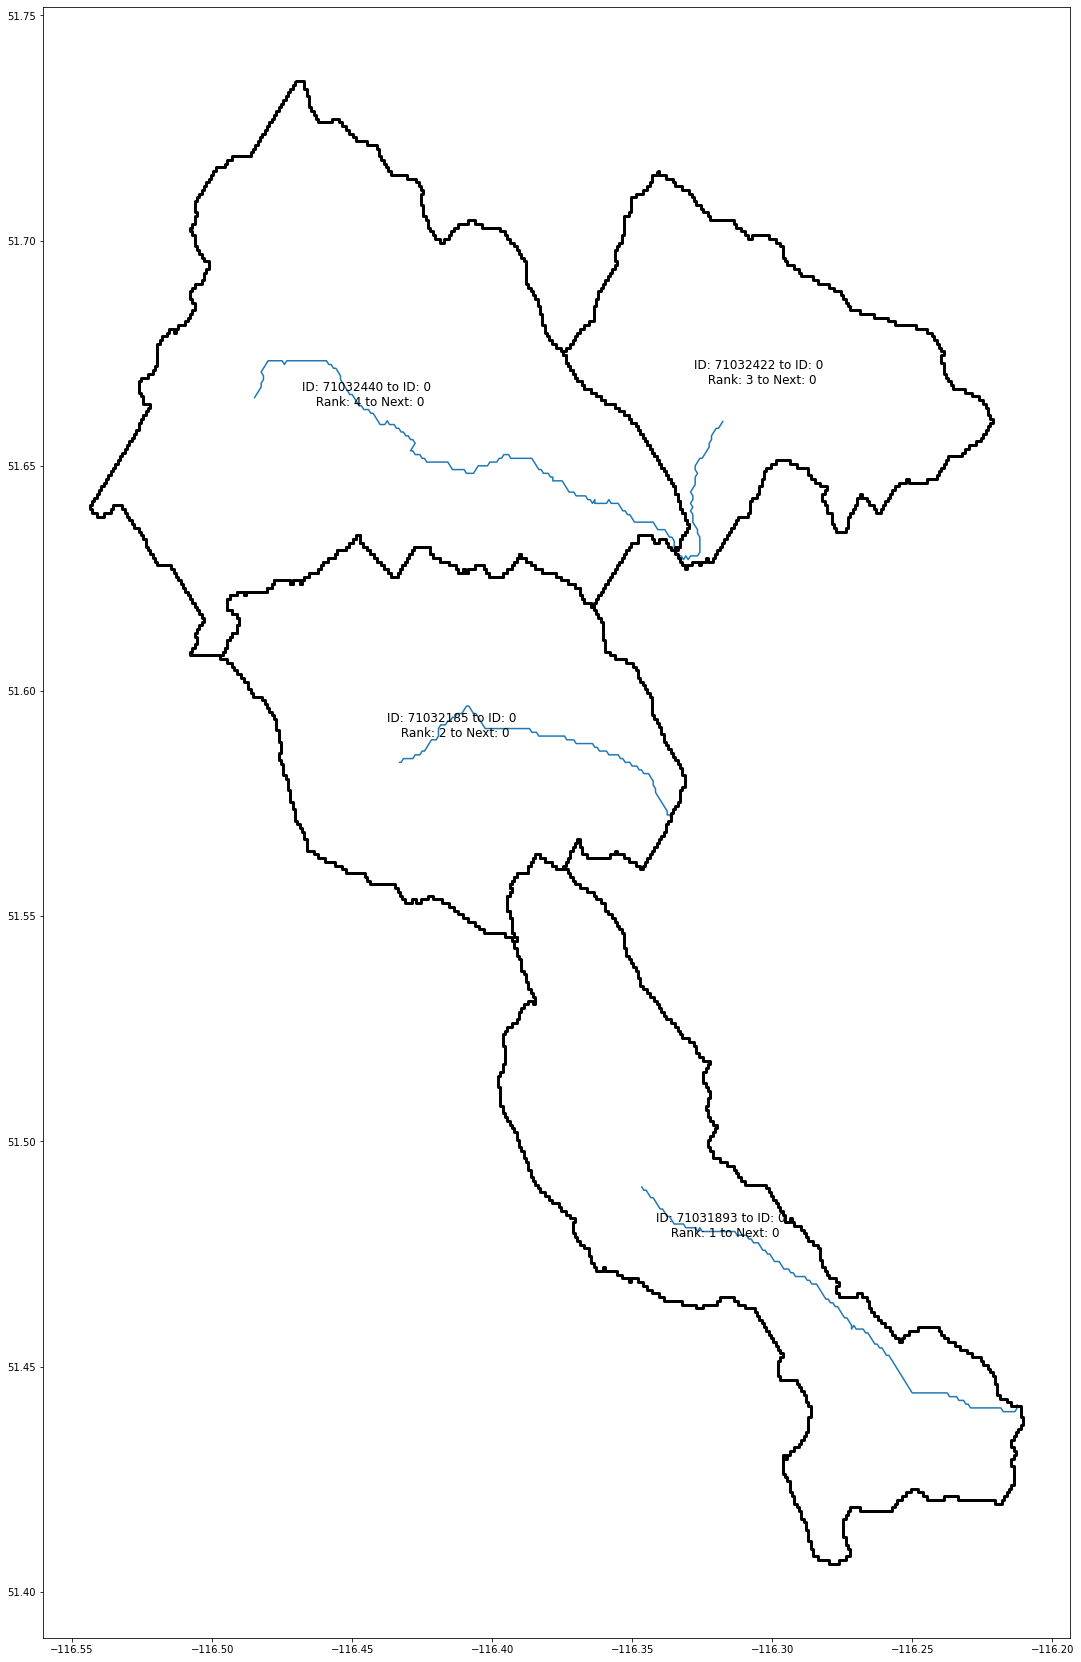

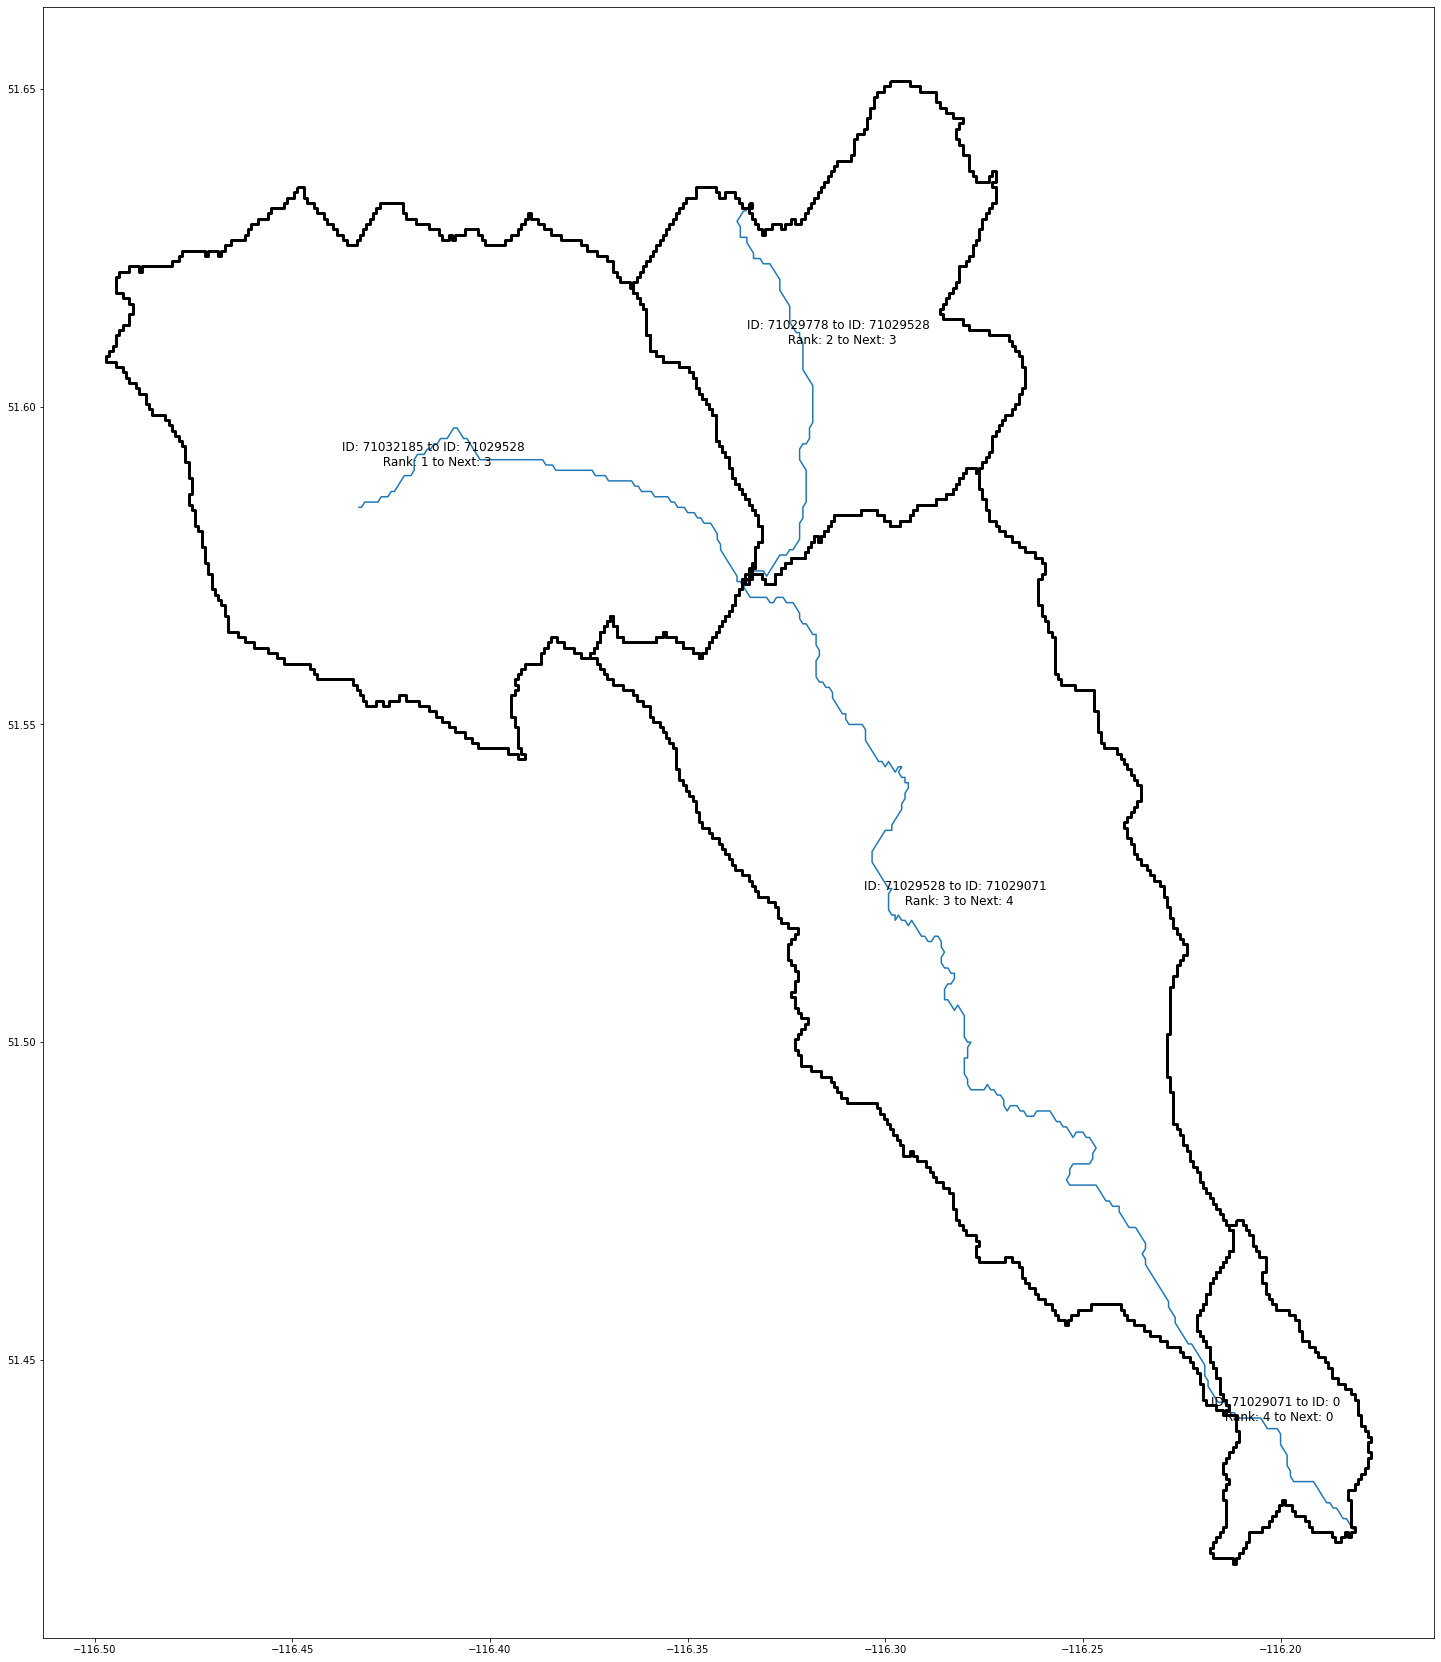

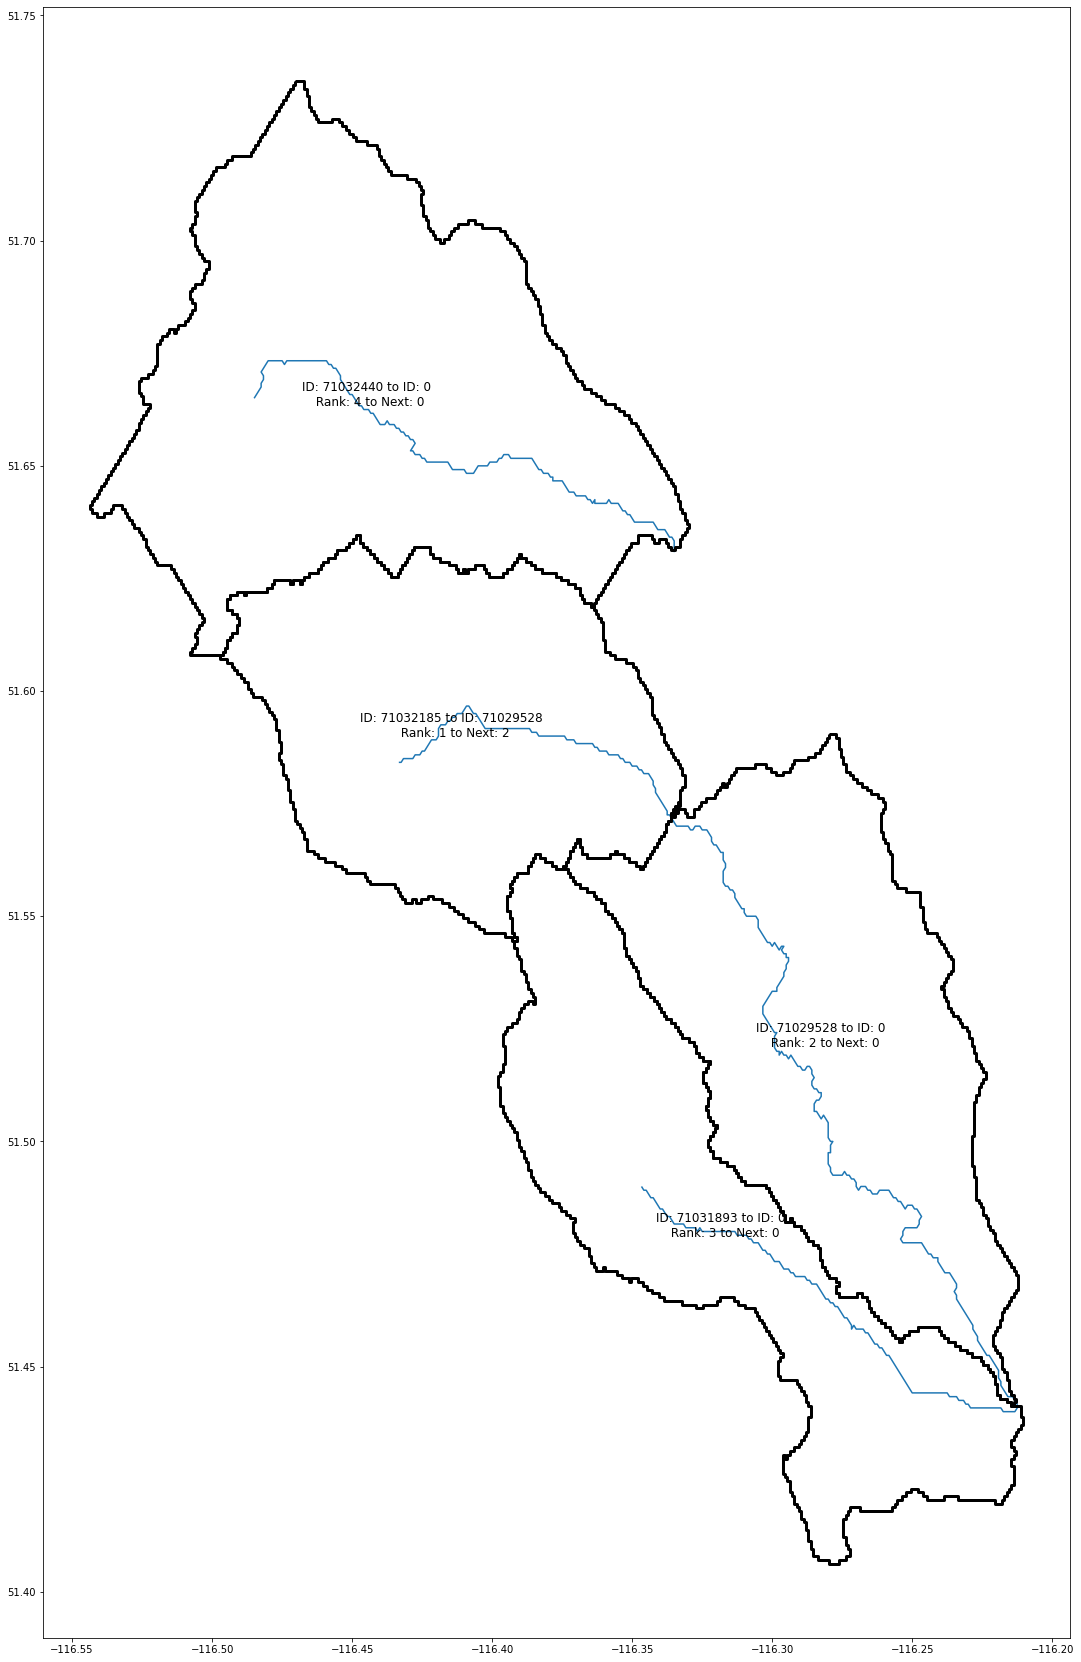

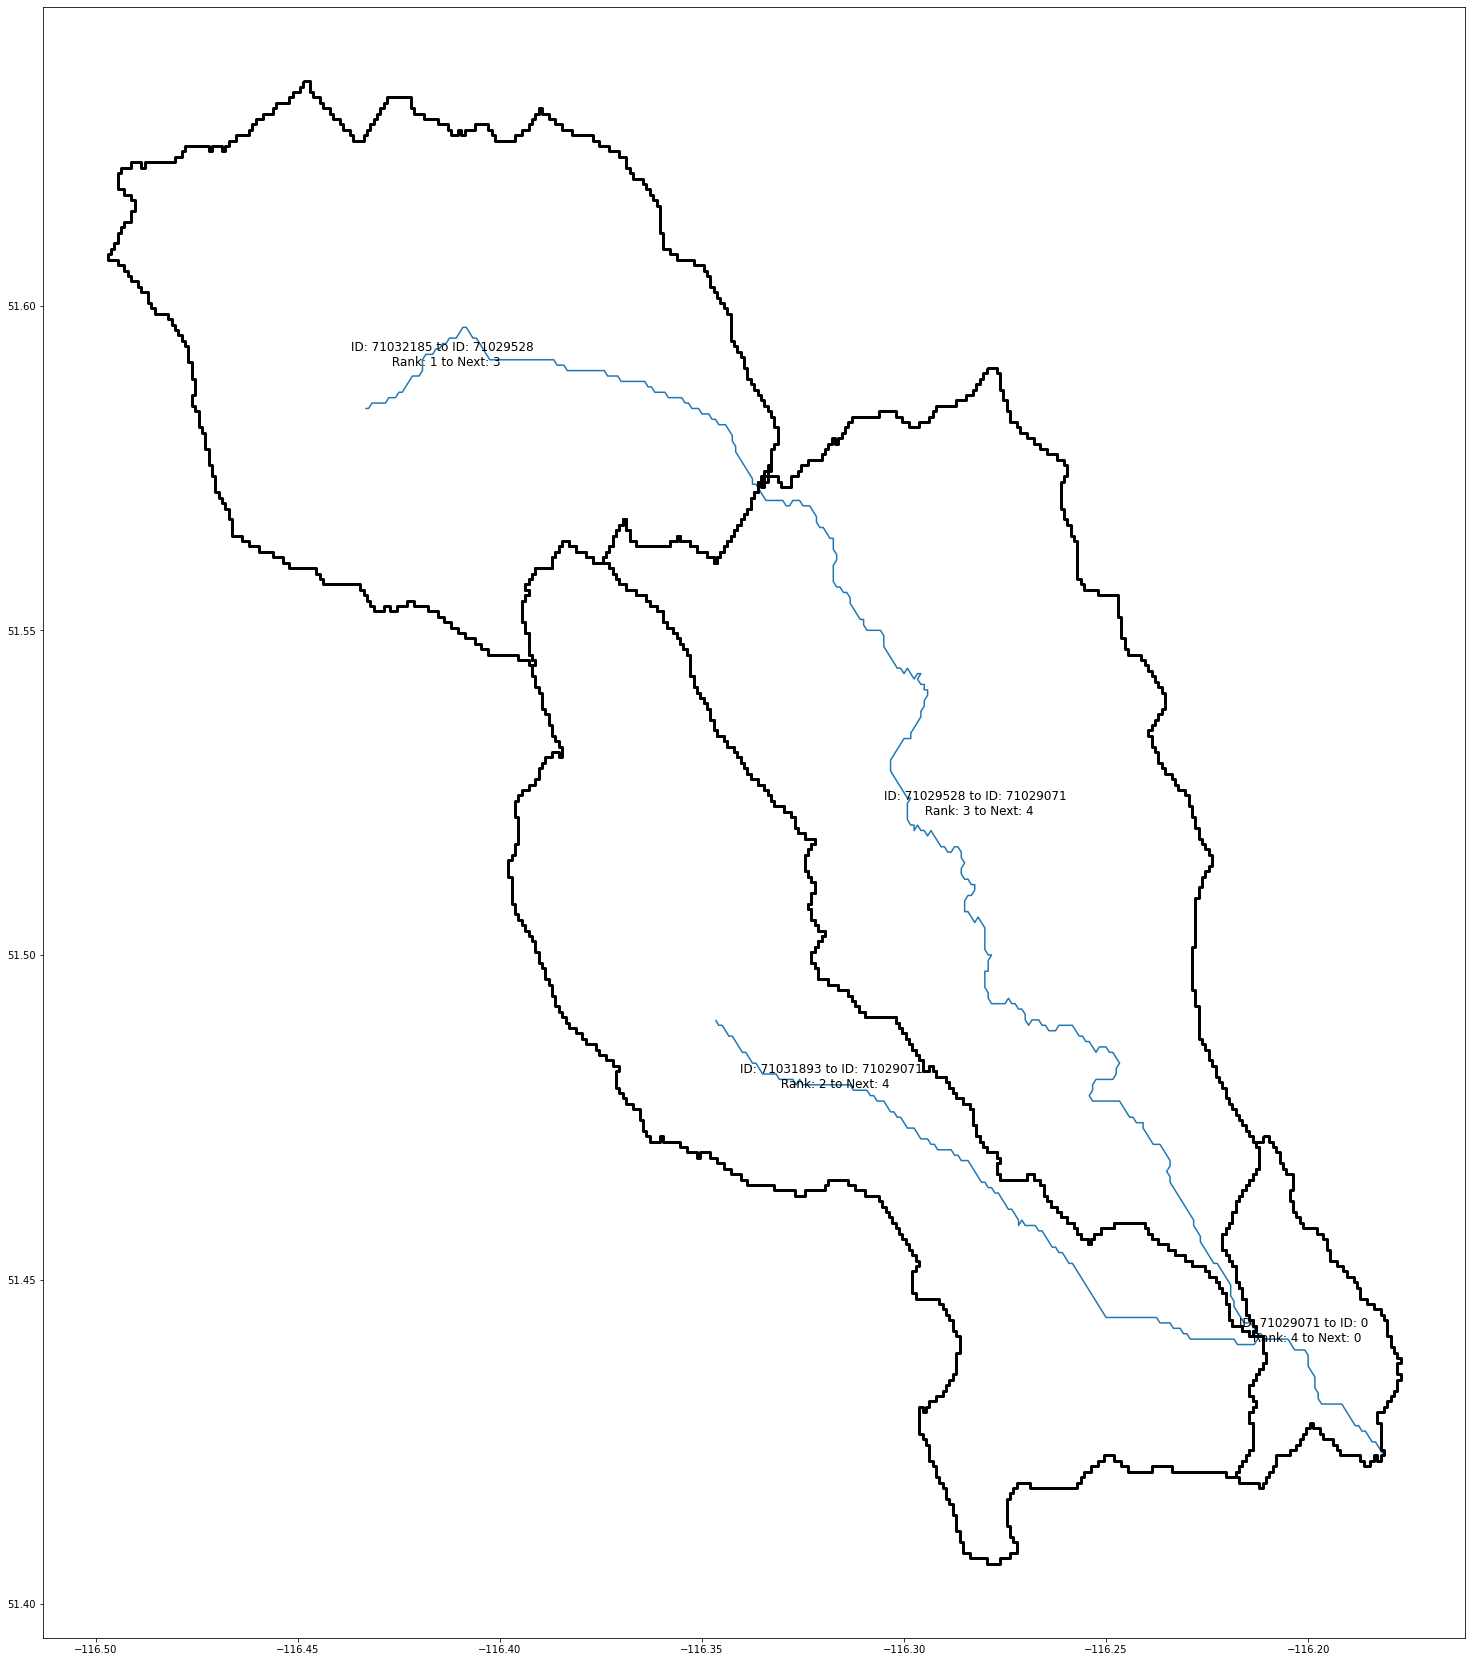

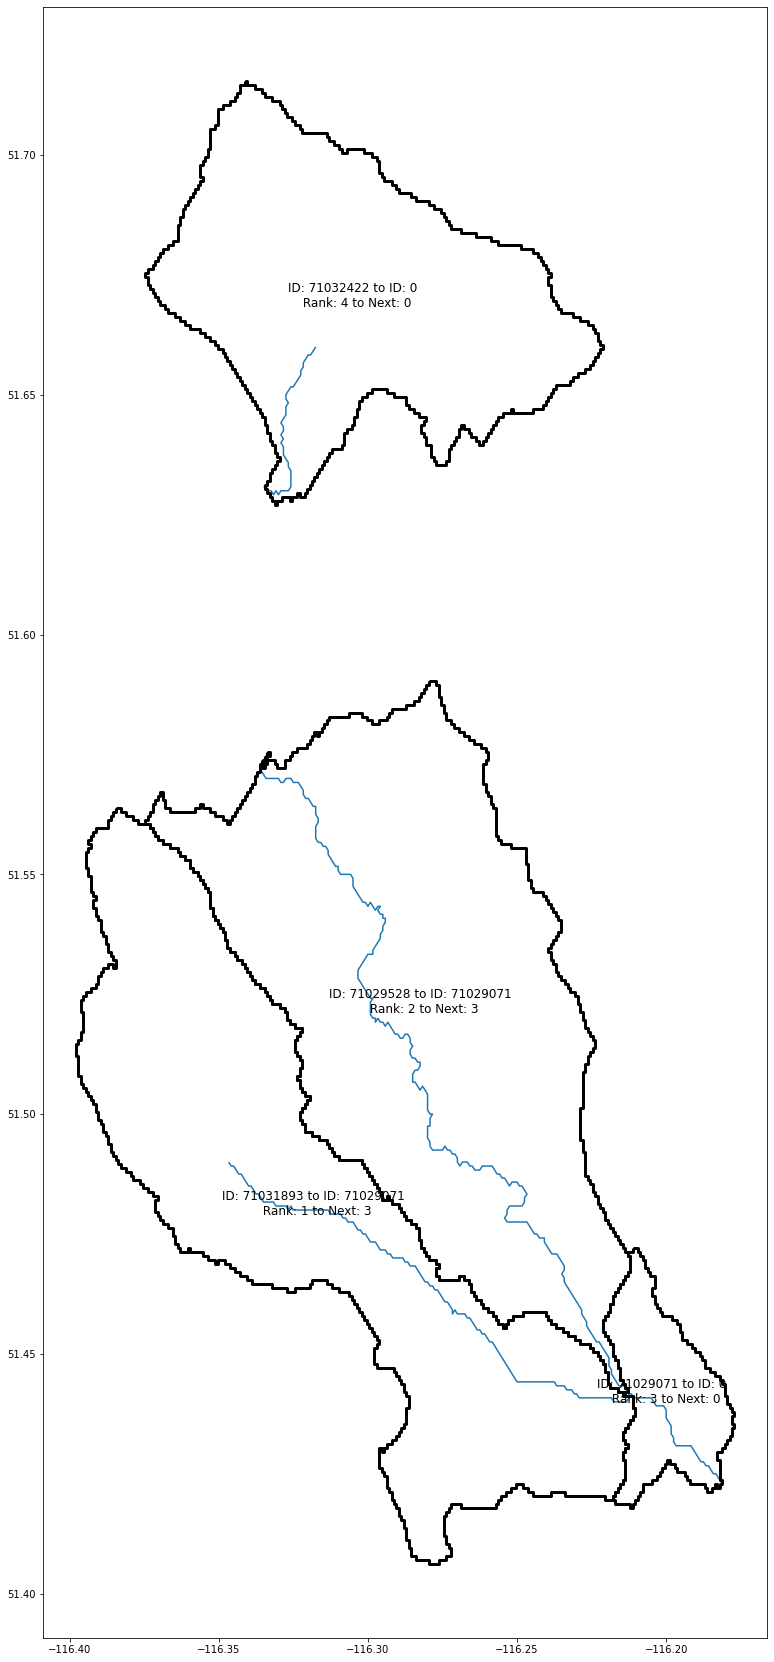

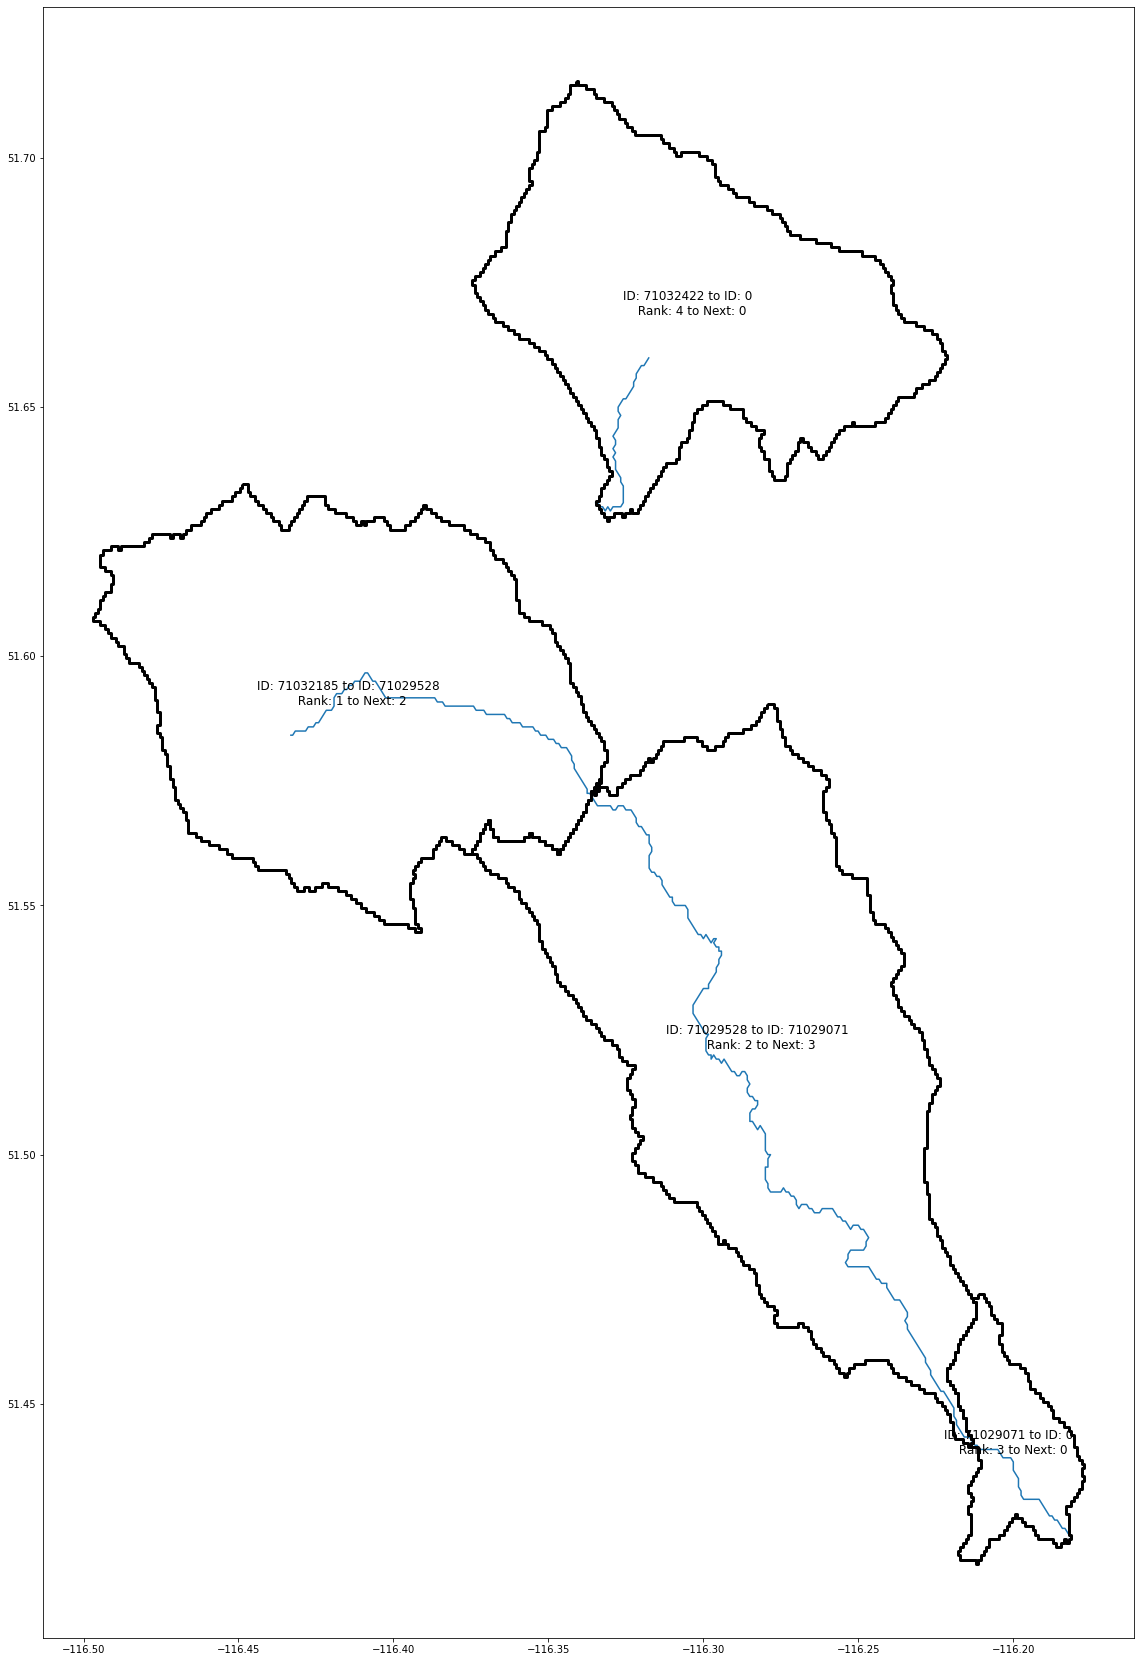

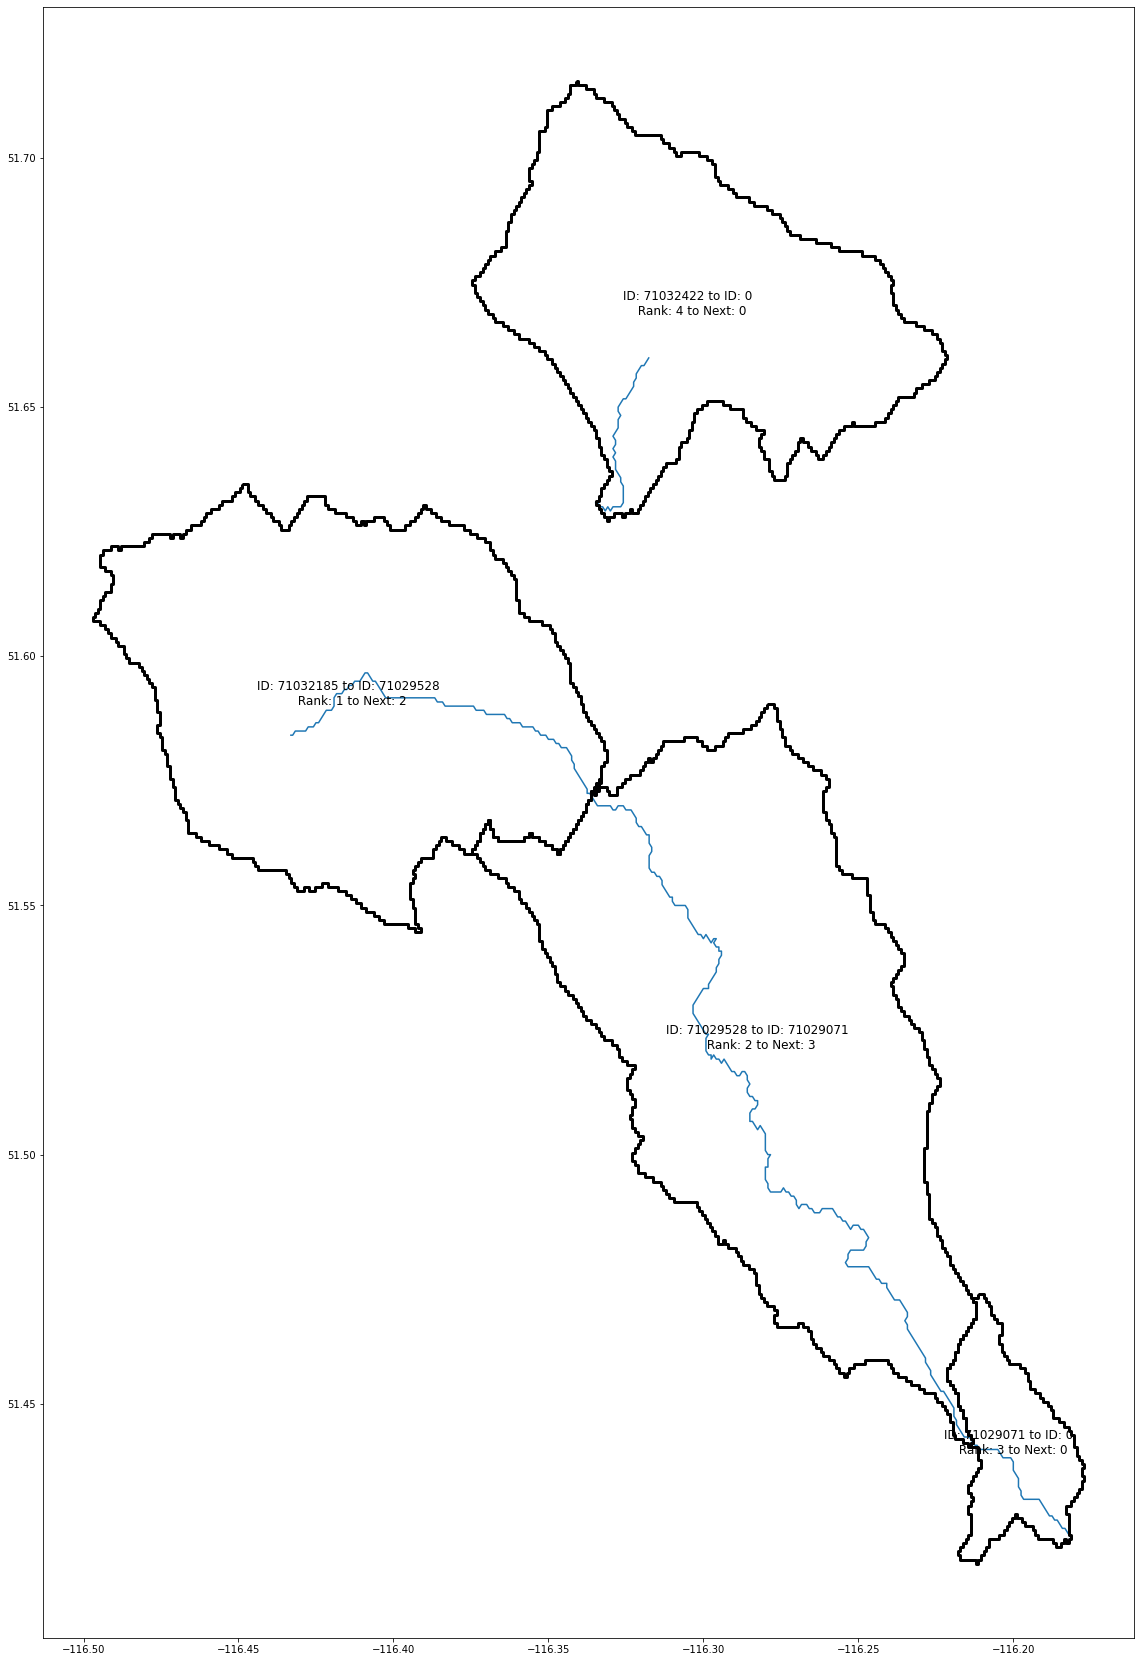

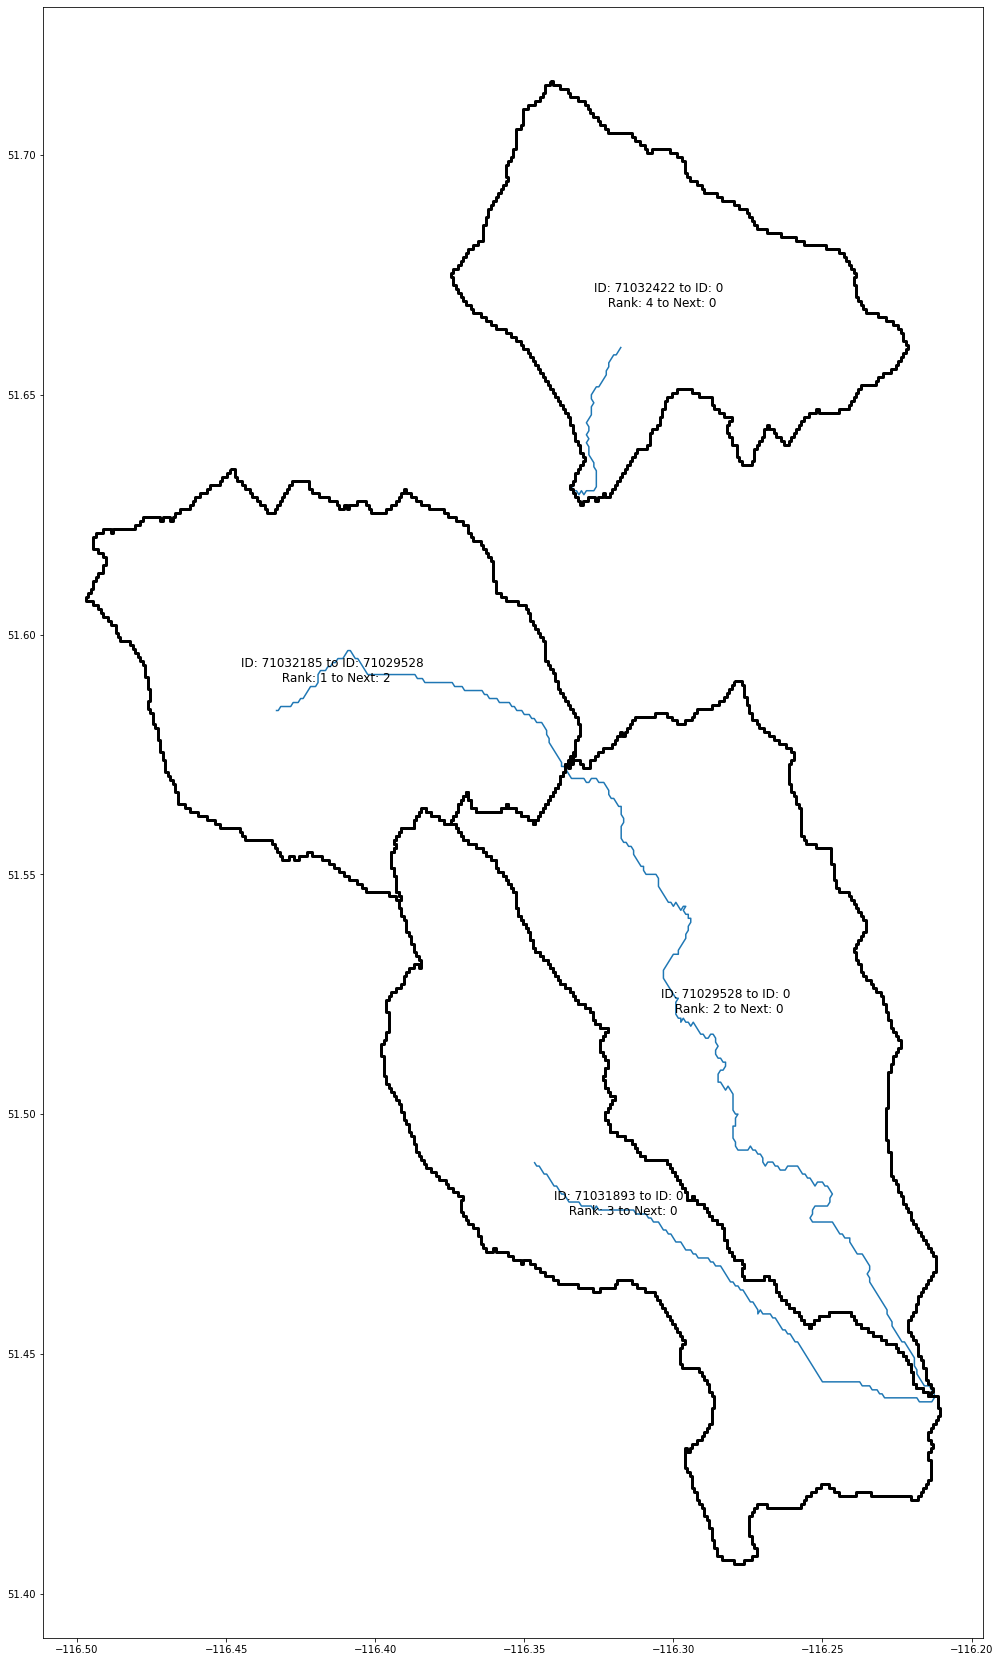

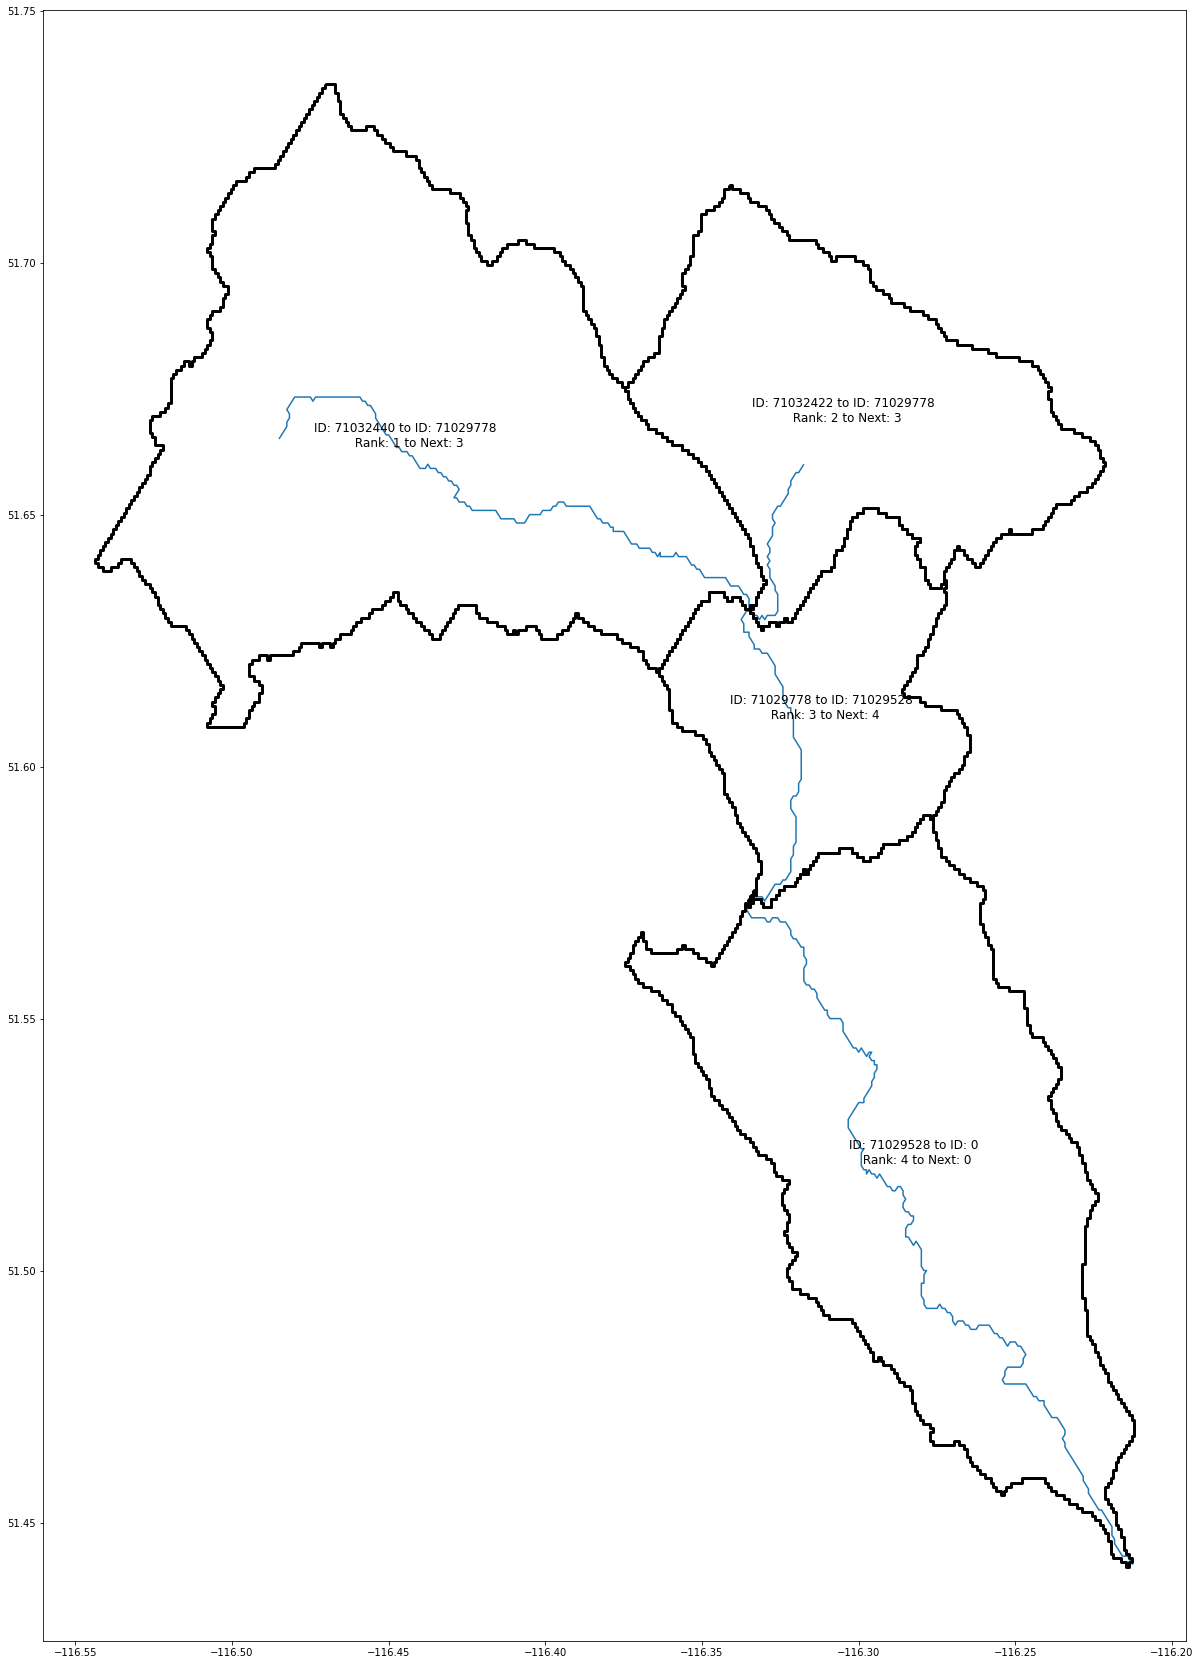

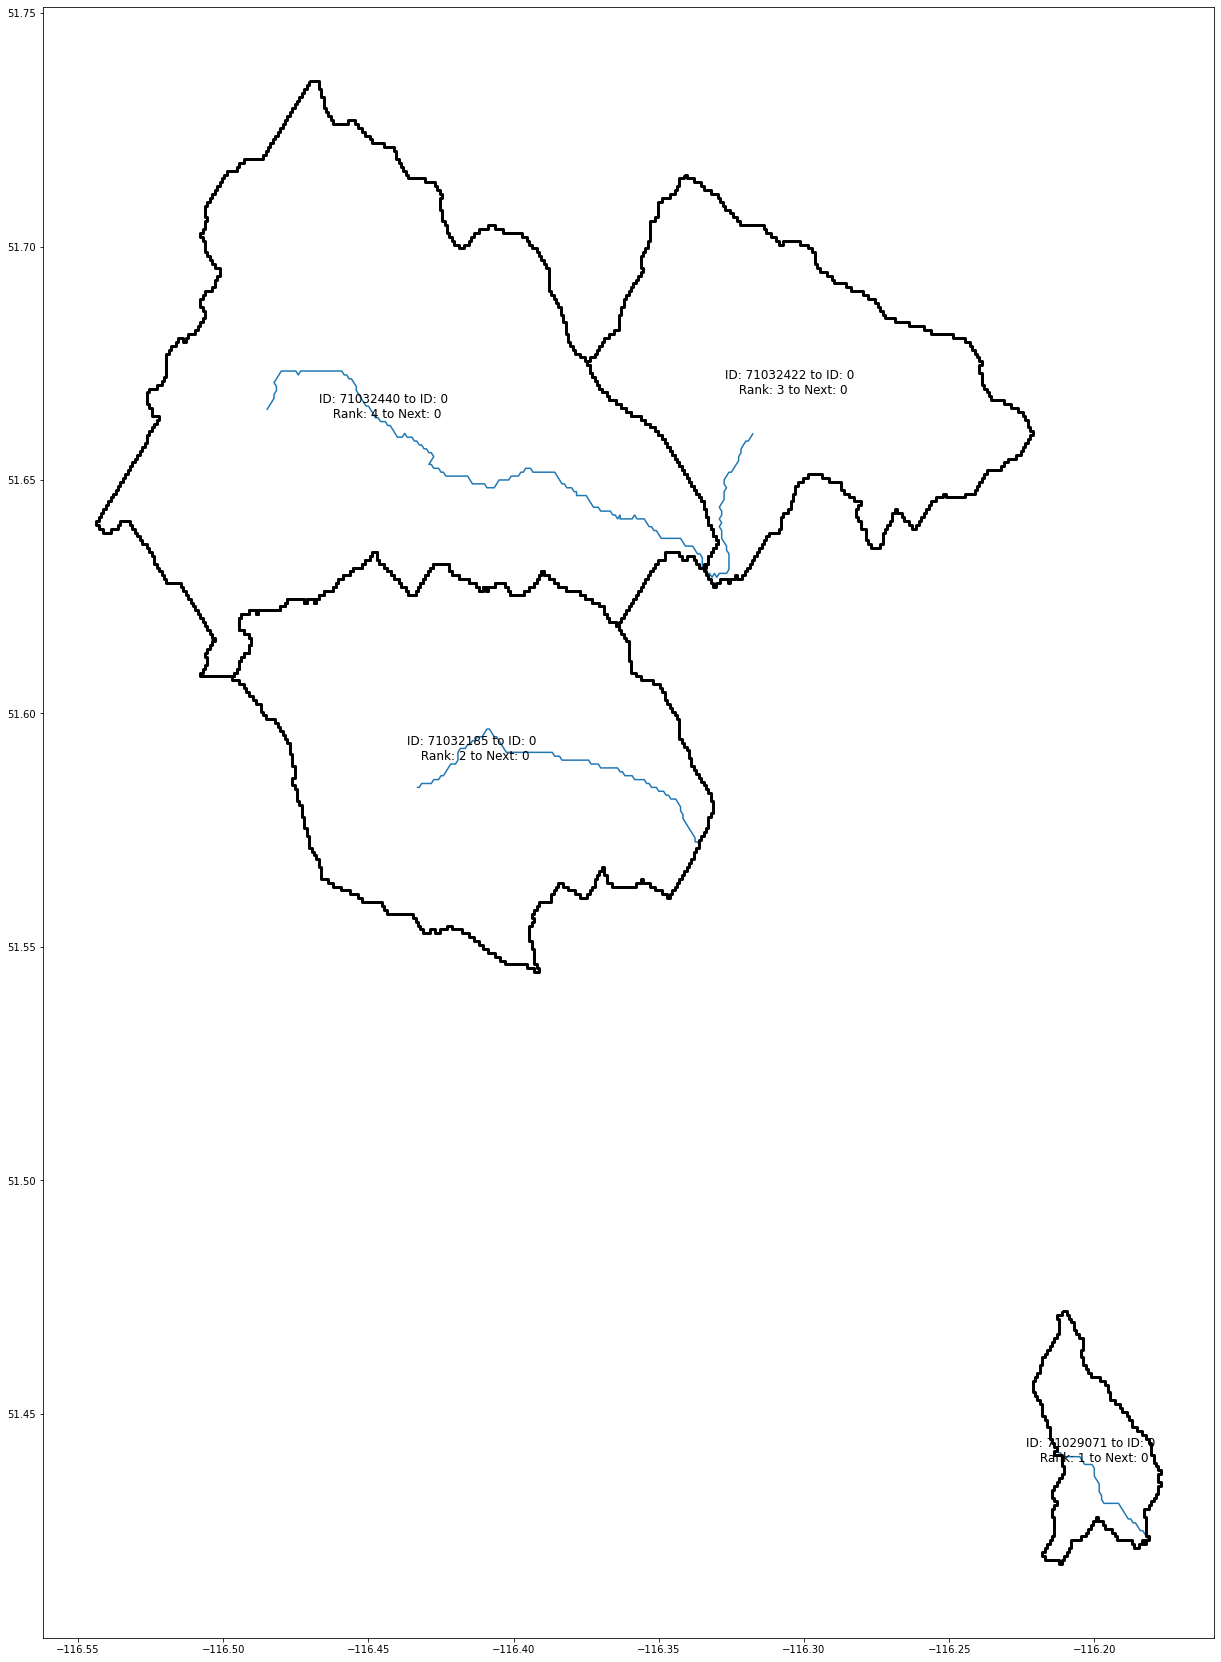

In [51]:
# another test of the code with non connected river segment
import geopandas as gpd
import matplotlib.pyplot as plt

for k in np.arange(10):

    cat = gpd.read_file('../data/shapefiles/catchment/BowAtLouise_cat.shp')
    riv = gpd.read_file('../data/shapefiles/river_network/BowAtLouise_riv.shp')
    cat_org = cat.copy()

    COMIDs = riv['COMID'].values

    selected_values = np.random.choice(COMIDs, 4, replace=False)

    cat = cat[cat['COMID'].isin(selected_values)]; cat = cat.reset_index(drop=True)
    riv = riv[riv['COMID'].isin(selected_values)]; riv = riv.reset_index(drop=True)

    df = new_rank_extract(np.array(riv['COMID'].values),\
                                  np.array(riv['NextDownID'].values),\
                                  -9999)  # outflow at lake Loiuse 
    df


    # visualize
    fig, ax = plt.subplots(figsize=(40,30))

    ax.set_facecolor('white')
    fig.patch.set_facecolor('white')

    #
    cat.plot(ax = ax, zorder=10, color= 'none', linewidth=3)
    #cat_org.plot(ax = ax, zorder=10, color= 'none', linewidth=0.5)
    riv.plot(ax =ax)

    # print ID and rank on the map
    cat['x']=cat.centroid.x
    cat['y']=cat.centroid.y

    for index, row in df.iterrows():

        # get the lat lon of centroid from cat
        cat_slice = cat [cat['COMID']==row['Segid']]
        idx = cat_slice.index.item()
        print(idx)

        #
        text = 'ID: ' + str(row['Segid'])+' to ID: '+str(row['tosegment'])+' \n Rank: '+str(row['Rank'])+ ' to Next: ' +str(row['Next'])
        print(text)

        plt.text(cat_slice['x'].item(), cat_slice['y'].item(), text, fontsize=12, color='k', ha='center', va='center')

